<a href="https://colab.research.google.com/github/Afix0/BP/blob/main/SDUEBA_007_continuos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Dependencies
import numpy as np
import pandas as pd
from collections import Counter
!pip install gensim
import gensim
from gensim.models import Word2Vec
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import export_text
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import LabelEncoder
import re
import os
import string
!pip install subgroups
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

In [2]:
#SDUEBA Parameters:
"""
vector_space_dimention  ... dimention of the embedding vector space
n_clusters              ... number of clusters to be found
max_depth               ... maximal depth of the decision tree
test_size               ... size of the test set for training the decision tree
mixed_threashold        ... threshold for classifying a cluster as mixed
"""

vector_space_dimension = 10
n_clusters = 15
clustering_method = "spherical_kmeans"      #"agglomerative"/"spherical_kmeans"

max_depth = 2
test_size = 0.2
tree_accuracy_threshold = 0.9

#Quality metric parameters
description_length_limit = 2
difference_limit = 0
subgroup_size_limit = 10


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


array([[<Axes: title={'center': 'vote_average'}>]], dtype=object)

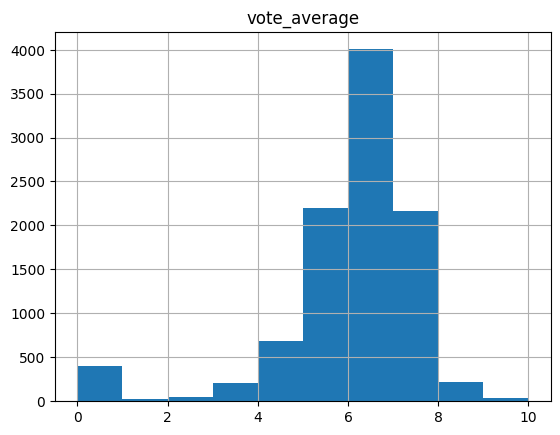

In [3]:
#Data augemntation
movies = pd.read_csv("hf://datasets/bloc4488/TMDB-all-movies/TMDB_10k_movies.csv")
features_raw = movies[['production_companies', 'production_countries', 'spoken_languages', 'genres', 'cast', 'director', 'director_of_photography', 'writers', 'producers', 'music_composer']]
target_df = pd.DataFrame()
target_df['vote_average'] = movies['vote_average']
target_column = 'vote_average'
# features_raw.head()
# target_df.head()
# features_raw.head()
target_df.hist()

In [4]:
#Data augemntation sentence creation
features_df = pd.DataFrame()
for column in features_raw.columns:
    split_columns = column.split("_")
    jointed_columns = ' '.join(split_columns)
    features_df[column] = features_raw[column].apply(lambda x: f"{jointed_columns} is {x}")

sentences = []
for i in range(len(features_df)):
    sentence = []
    for word in features_df.iloc[i]:
        sentence.append(word)
    sentences.append(sentence)

In [5]:
#Word2Vec training and clustering
class Word2VecModel:
    def __init__(self, sentences, vector_size, window=5, min_count=1):
        self.model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count)

    def get_embedding(self, sentence):
        word_embeddings = [self.model.wv[word] for word in sentence if word in self.model.wv]
        return np.mean(word_embeddings, axis=0) if word_embeddings else np.zeros(self.model.vector_size)

class SentenceEmbedder:
    def __init__(self, word2vec_model):
        self.word2vec_model = word2vec_model

    def generate_embeddings(self, sentences, normalize=False):
        embeddings = np.array([self.word2vec_model.get_embedding(sentence) for sentence in sentences])
        return embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True) if normalize else embeddings

class SphericalKMeans:
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.cluster_centers_ = None

    def fit(self, X):
        np.random.seed(self.random_state)
        X = normalize(X, norm='l2', axis=1)

        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        self.cluster_centers_ = X[indices]

        for _ in range(self.max_iter):
            # Compute cosine similarity (dot product since vectors are normalized)
            similarities = X @ self.cluster_centers_.T
            labels = np.argmax(similarities, axis=1)

            new_centroids = np.array([normalize(X[labels == j].mean(axis=0).reshape(1, -1))
                                      if np.any(labels == j) else self.cluster_centers_[j]
                                      for j in range(self.n_clusters)]).squeeze()

            if np.linalg.norm(new_centroids - self.cluster_centers_) < self.tol:
                break

            self.cluster_centers_ = new_centroids

        self.labels_ = labels
        return self

    def predict(self, X):
        X = normalize(X, norm='l2', axis=1)
        similarities = X @ self.cluster_centers_.T
        return np.argmax(similarities, axis=1)

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

class ClusteringModel:
    def __init__(self, n_clusters, method="spherical_kmeans", random_state=42):
        self.n_clusters = n_clusters
        self.method = method
        self.random_state = random_state
        self.model = self._initialize_model()

    def _initialize_model(self):
        if self.method == "agglomerative":
            return AgglomerativeClustering(n_clusters=self.n_clusters, metric='cosine', linkage='average')
        elif self.method == "spherical_kmeans":
            return SphericalKMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        else:
            raise ValueError("Unsupported clustering method")

    def fit_predict(self, embeddings):
        return self.model.fit_predict(embeddings)

word2vec_model = Word2VecModel(sentences, vector_size=vector_space_dimension)
sentence_embedder = SentenceEmbedder(word2vec_model)
embeddings = sentence_embedder.generate_embeddings(sentences, normalize=normalize)

clustering_model = ClusteringModel(n_clusters, method=clustering_method)
labels = clustering_model.fit_predict(embeddings)


In [6]:
#Decision tree training
class DecisionTreeTrainer:
    def __init__(self, features_raw, labels, max_depth, subgroup_size_limit, test_size, random_state=73, print_acc=True):
        self.features_raw = features_raw
        self.labels = labels
        self.max_depth = max_depth
        self.subgroup_size_limit = subgroup_size_limit
        self.test_size = test_size
        self.random_state = random_state
        self.print_acc = print_acc

        self.encoder = OneHotEncoder()
        self.decision_trees = {}
        self.accuracies = {}

        self._prepare_data()
        self._train_trees()

    def _prepare_data(self):
        features_classify = self.features_raw.assign(cluster=self.labels)

        cluster_counts = features_classify['cluster'].value_counts()
        valid_clusters = cluster_counts[cluster_counts >= self.subgroup_size_limit].index

        features_classify = features_classify[features_classify['cluster'].isin(valid_clusters)]

        X = features_classify.drop(columns=['cluster'])
        y = features_classify['cluster']

        X_encoded = self.encoder.fit_transform(X)
        self.X_df = pd.DataFrame(X_encoded.toarray(), columns=self.encoder.get_feature_names_out())

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X_df, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )

    def _train_trees(self):
        for cluster in sorted(self.y_train.unique()):
            y_train_binary = (self.y_train == cluster).astype(int)
            y_test_binary = (self.y_test == cluster).astype(int)

            clf = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_leaf=self.subgroup_size_limit, random_state=self.random_state)
            clf.fit(self.X_train, y_train_binary)

            self.decision_trees[cluster] = clf

            y_pred = clf.predict(self.X_test)
            accuracy = accuracy_score(y_test_binary, y_pred)
            self.accuracies[cluster] = accuracy

            if self.print_acc:
                print(f"Accuracy for Cluster {cluster}: {accuracy:.4f}")
                print(classification_report(y_test_binary, y_pred))

    def get_trees(self):
        return self.decision_trees

    def get_accuracies(self):
        return self.accuracies

tree_trainer = DecisionTreeTrainer(
    features_raw=features_raw,
    labels=labels,
    max_depth=max_depth,
    subgroup_size_limit=subgroup_size_limit,
    test_size=test_size,
    print_acc=False
)

In [7]:
# Subgroup creation and quality evaluation
def Quality_metric(cluster_mean, overall_mean, description_length, description_length_limit, difference_limit, subgroup_size_limit, cluster_size):
    difference = abs(cluster_mean - overall_mean)

    if difference < difference_limit or description_length > description_length_limit or cluster_size < subgroup_size_limit:
        return np.NaN

    return difference / description_length

class ClusterRuleExtractor:
    def __init__(self, data_frame, target_df, target_column, cluster_labels, feature_names, decision_trees, trees_acc, tree_accuracy_threshold):
        self.data_frame = data_frame
        self.target_df = target_df
        self.target_column = target_column
        self.cluster_labels = cluster_labels
        self.feature_names = feature_names
        self.decision_trees = decision_trees
        self.trees_acc = trees_acc
        self.tree_accuracy_threshold = tree_accuracy_threshold

        self.cluster_means = {}
        self.cluster_frequencies = {}
        self.rules_dict = {}
        self.unextractable_clusters = []
        self.R2_dict = {}

        self._compute_cluster_statistics()

    def _extract_rules_from_tree(self, tree, node=0, rule_list=None, rule_path=None):
        if rule_list is None:
            rule_list = []
        if rule_path is None:
            rule_path = []

        left_child = tree.tree_.children_left[node]
        right_child = tree.tree_.children_right[node]
        threshold = tree.tree_.threshold[node]
        feature = tree.tree_.feature[node]

        if left_child == -1 and right_child == -1:
            rule_list.append(" AND ".join(rule_path))
            return rule_list

        if left_child != -1:
            self._extract_rules_from_tree(tree, left_child, rule_list, rule_path + [f"{self.feature_names[feature]} <= {threshold:.2f}"])

        if right_child != -1:
            self._extract_rules_from_tree(tree, right_child, rule_list, rule_path + [f"{self.feature_names[feature]} > {threshold:.2f}"])

        return rule_list

    def _compute_cluster_statistics(self):
        overall_mean = self.target_df[self.target_column].mean()
        overall_variance = ((self.target_df[self.target_column] - overall_mean) ** 2).sum()
        N = len(self.target_df)

        for cluster in np.unique(self.cluster_labels):
            cluster_data = self.target_df[self.cluster_labels == cluster]
            cluster_size = len(cluster_data)

            if cluster_size == 0:
                self.cluster_means[cluster] = np.NaN
                self.cluster_frequencies[cluster] = 0
                self.R2_dict[cluster] = np.NaN
                continue

            cluster_mean = cluster_data[self.target_column].mean()
            ss_residual = ((cluster_data[self.target_column] - cluster_mean) ** 2).sum()
            R2 = 1 - (ss_residual / overall_variance) if overall_variance > 0 else 0

            self.cluster_means[cluster] = cluster_mean
            self.cluster_frequencies[cluster] = cluster_size
            self.R2_dict[cluster] = R2

            if cluster in self.decision_trees:
                accuracy = self.trees_acc.get(cluster, 0)
                if accuracy < self.tree_accuracy_threshold:
                    self.unextractable_clusters.append(cluster)
                    self.rules_dict[cluster] = ["Accuracy lower than the given threshold"]
                else:
                    rules_list = self._extract_rules_from_tree(self.decision_trees[cluster])
                    self.rules_dict[cluster] = rules_list if rules_list else self.unextractable_clusters.append(cluster)
            else:
                self.unextractable_clusters.append(cluster)

    def print_summary(self):
        print("\nFormatted Cluster Summary:")
        for cluster in sorted(self.cluster_frequencies.keys()):
            print(f"Cluster {cluster}: size = {self.cluster_frequencies[cluster]}, mean = {self.cluster_means[cluster]:.4f}, R² = {self.R2_dict[cluster]:.8f}")

            rules = self.rules_dict.get(cluster, None)
            if rules is None:
                rules = ["No rules extracted"]
            for rule in rules:
                print(f"  - {rule}")

        print("\nUnextractable Clusters:", self.unextractable_clusters)


clusters = ClusterRuleExtractor(
    data_frame=features_df,
    target_df=target_df,
    target_column=target_column,
    cluster_labels=labels,
    feature_names=list(tree_trainer.X_df.columns),
    decision_trees=tree_trainer.get_trees(),
    trees_acc=tree_trainer.get_accuracies(),
    tree_accuracy_threshold=tree_accuracy_threshold
)
clusters.print_summary()


Formatted Cluster Summary:
Cluster 0: size = 19, mean = 6.4497, R² = 0.99895249
  - production_countries_Spain, United States of America <= 0.50 AND spoken_languages_English, Magyar <= 0.50
  - production_countries_Spain, United States of America <= 0.50 AND spoken_languages_English, Magyar > 0.50
  - production_countries_Spain, United States of America > 0.50
Cluster 1: size = 509, mean = 6.4383, R² = 0.97418211
  - spoken_languages_Italiano <= 0.50 AND spoken_languages_English <= 0.50
  - spoken_languages_Italiano <= 0.50 AND spoken_languages_English > 0.50
  - spoken_languages_Italiano > 0.50 AND music_composer_nan <= 0.50
  - spoken_languages_Italiano > 0.50 AND music_composer_nan > 0.50
Cluster 2: size = 1015, mean = 5.3925, R² = 0.80450959
  - Accuracy lower than the given threshold
Cluster 3: size = 22, mean = 6.5486, R² = 0.99893283
  - spoken_languages_English,  <= 0.50 AND production_countries_China, Hong Kong <= 0.50
  - spoken_languages_English,  <= 0.50 AND production_cou

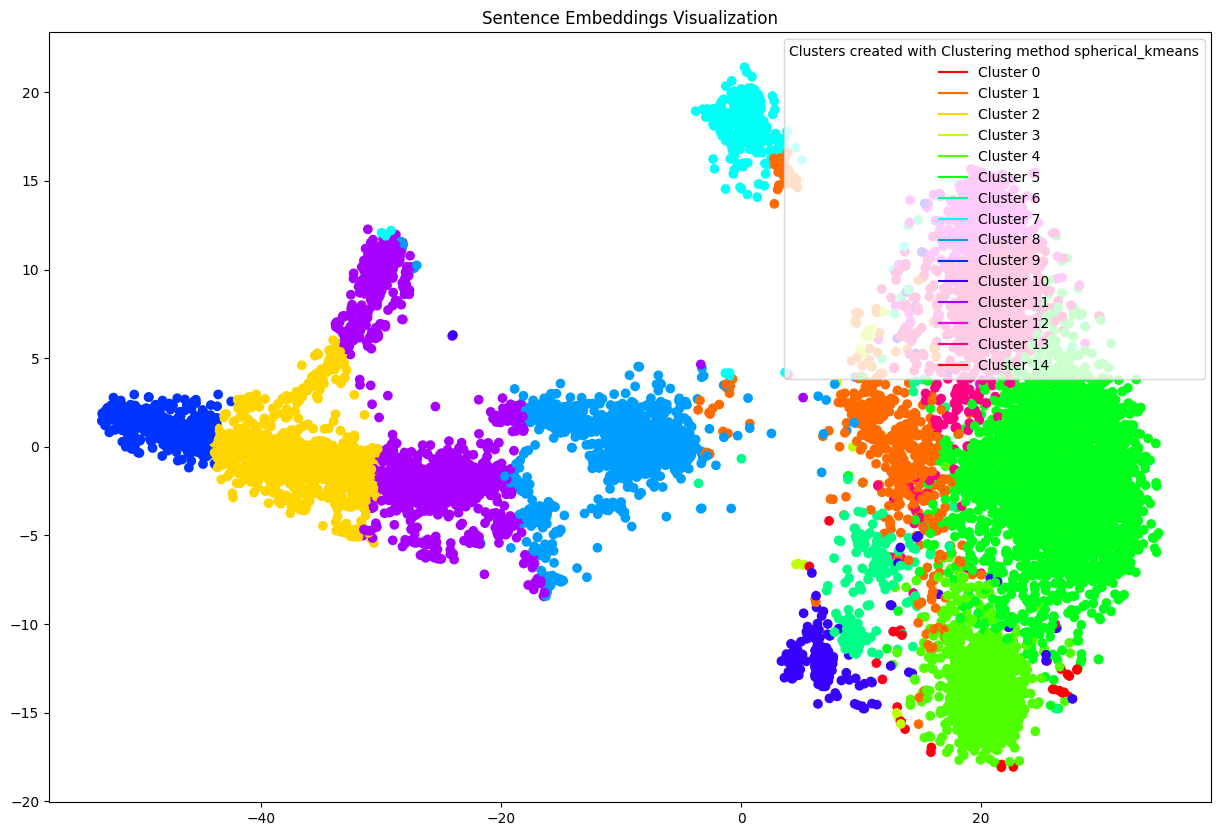

In [8]:
# Clusters visualization
def plot_sentence_embeddings(embeddings, cluster_labels=None, target_labels=None, clustering_method=None):
    plt.figure(figsize=(15, 10))
    tsne = TSNE(n_components=2, random_state= 73, perplexity=300, learning_rate=200, max_iter=1000)
    embeddings_2d = tsne.fit_transform(np.array(embeddings))
    cmap = plt.colormaps['hsv']


    n_clusters = len(set(cluster_labels))
    colors = cmap(np.linspace(0, 1, n_clusters))
    handles = [plt.Line2D([], [], color=color) for color in colors]
    labels = [f"Cluster {i}" for i in range(n_clusters)]
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors[cluster_labels])

    plt.legend(handles=handles, labels=labels, title=f"Clusters created with {clustering_method}", loc = "upper right")
    plt.title(f"Sentence Embeddings Visualization")
plot_sentence_embeddings(embeddings, cluster_labels=labels, clustering_method=f"Clustering method {clustering_method}")

In [12]:
class SubgroupCreator:
    def __init__(self, X_df, targets_df, target_column):
        self.X_df = X_df
        self.targets_df = targets_df
        self.target_column = target_column
        self.subgroup_means = {}
        self.R2_dict = {}
        self.Quality_dict = {}
        self.subgroups = {}
        self.covered_indices_global = set()

    def evaluate_rule(self, rule_str, covered_indices_set, overall_mean, overall_variance):
        parts = rule_str.split(" AND ")
        mask = pd.Series(True, index=self.X_df.index)

        description = []
        for part in parts:
            try:
                feature_operator, value = part.rsplit(" ", 1)
                value = float(value)

                if "<=" in feature_operator:
                    feature, operator = feature_operator.rsplit(" ", 1)
                    mask &= self.X_df[feature] <= value
                elif ">" in feature_operator:
                    feature, operator = feature_operator.rsplit(" ", 1)
                    mask &= self.X_df[feature] > value
                else:
                    raise ValueError(f"Invalid rule format: {part}")

                description.append(f"{feature} {operator} {value}")

            except ValueError:
                raise ValueError(f"Invalid rule structure: {part}")

        covered_indices = set(self.X_df[mask].index) - covered_indices_set
        covered_indices_set.update(covered_indices)
        covered_targets = self.targets_df.loc[list(covered_indices), self.target_column]

        if len(covered_targets) == 0:
            return np.NaN, np.NaN, covered_indices, description

        cluster_mean = covered_targets.mean()
        ss_residual = ((covered_targets - cluster_mean) ** 2).sum()
        R2 = 1 - (ss_residual / overall_variance) if overall_variance > 0 else 0

        return cluster_mean, R2, covered_indices, description

    def evaluate_all_clusters(self, subgroups):
        overall_mean = self.targets_df[self.target_column].mean()
        overall_variance = ((self.targets_df[self.target_column] - overall_mean) ** 2).sum()

        self.covered_indices_global.clear()

        with open("results_SDUEBA.txt", "w") as f:
            for cluster, rules_list in subgroups.rules_dict.items():
                if cluster in subgroups.unextractable_clusters:
                    continue

                covered_indices_set = set()

                for idx, rule_str in enumerate(rules_list):
                    letter_index = string.ascii_lowercase[idx]
                    subgroup_label = f"{cluster}.{letter_index}"

                    subgroup_mean, R2, covered_indices, description = self.evaluate_rule(
                        rule_str, covered_indices_set, overall_mean, overall_variance
                    )

                    if np.isnan(subgroup_mean):
                        continue

                    self.subgroup_means[subgroup_label] = subgroup_mean
                    self.R2_dict[subgroup_label] = R2
                    self.subgroups[subgroup_label] = covered_indices
                    self.covered_indices_global.update(covered_indices)

                    description_str = ", ".join(str(item) for item in description)
                    self.Quality_dict[subgroup_label] = Quality_metric(
                        cluster_mean=subgroup_mean,
                        overall_mean=overall_mean,
                        description_length=len(description),
                        description_length_limit=description_length_limit,
                        difference_limit=difference_limit,
                        subgroup_size_limit=subgroup_size_limit,
                        cluster_size=len(covered_indices),
                    )

                    f.write(
                        f"Description: [{description_str}], Target Mean: {subgroup_mean:.4f} ; "
                        f"R² = {R2:.8f} ; "
                        f"Quality Metric = {self.Quality_dict[subgroup_label]:.8f} ; "
                        f"Subgroup Size = {len(covered_indices)}\n"
                    )

            total_coverage_ratio = len(self.covered_indices_global) / len(self.targets_df)
            f.write(f"Total coverage: {total_coverage_ratio:.4f}\n")


evaluator = SubgroupCreator(tree_trainer.X_df, target_df, target_column=target_column)
evaluator.evaluate_all_clusters(clusters)


In [14]:
subgroups_to_read = n_clusters*5
with open("./results_SDUEBA.txt", "r") as file:
    while(subgroups_to_read > 0):
        current_line = file.readline()
        print(current_line.strip())
        subgroups_to_read = subgroups_to_read - 1

Description: [production_countries_Spain, United States of America <= 0.5, spoken_languages_English, Magyar <= 0.5], Target Mean: 6.0118 ; R² = 0.00128350 ; Quality Metric = 0.00002143 ; Subgroup Size = 9973
Description: [production_countries_Spain, United States of America <= 0.5, spoken_languages_English, Magyar > 0.5], Target Mean: 6.0218 ; R² = 0.99961585 ; Quality Metric = 0.00495821 ; Subgroup Size = 14
Description: [production_countries_Spain, United States of America > 0.5], Target Mean: 6.0341 ; R² = 0.99910095 ; Quality Metric = 0.02220762 ; Subgroup Size = 13
Description: [spoken_languages_Italiano <= 0.5, spoken_languages_English <= 0.5], Target Mean: 5.9504 ; R² = 0.32317200 ; Quality Metric = 0.03075965 ; Subgroup Size = 5097
Description: [spoken_languages_Italiano <= 0.5, spoken_languages_English > 0.5], Target Mean: 6.0890 ; R² = 0.70011971 ; Quality Metric = 0.03856094 ; Subgroup Size = 4758
Description: [spoken_languages_Italiano > 0.5, music_composer_nan <= 0.5], Tar

In [15]:
def sort_and_print_top_n(filepath, n):
    try:
        with open(filepath, 'r') as file:
            document = file.read()
    except FileNotFoundError:
        print(f"Error: File not found at '{filepath}'")
        return
    except Exception as e:
        print(f"Error reading file: {e}")
        return

    lines = document.strip().split('\n')
    data = []

    for line in lines:
        if "Total coverage:" in line:
            continue

        match = re.search(r'Quality Metric = ([\d.]+|(?:nan))', line)
        if match:
            quality_metric = match.group(1)
            if quality_metric == 'nan':
                quality_metric = -math.inf
            else:
                quality_metric = float(quality_metric)
            data.append((quality_metric, line))

    # Sort by quality metric (descending)
    sorted_data = sorted(data, key=lambda x: x[0], reverse=True)

    # Print top `n` subgroups
    for i in range(min(n, len(sorted_data))):
        print(sorted_data[i][1])

filepath = 'results_SDUEBA.txt'
top_n = 15
sort_and_print_top_n(filepath, top_n)

Description: [spoken_languages_Deutsch > 0.5, music_composer_nan > 0.5], Target Mean: 4.3928 ; R² = 0.86919053 ; Quality Metric = 0.80952936 ; Subgroup Size = 454
Description: [spoken_languages_Italiano > 0.5, music_composer_nan > 0.5], Target Mean: 4.7067 ; R² = 0.98884221 ; Quality Metric = 0.65256798 ; Subgroup Size = 45
Description: [spoken_languages_English,  > 0.5], Target Mean: 6.5912 ; R² = 0.99966457 ; Quality Metric = 0.57936599 ; Subgroup Size = 17
Description: [production_countries_Japan > 0.5, music_composer_nan <= 0.5], Target Mean: 7.0716 ; R² = 0.99714328 ; Quality Metric = 0.52988502 ; Subgroup Size = 122
Description: [director_nan <= 0.5, producers_nan > 0.5], Target Mean: 5.0592 ; R² = 0.76731640 ; Quality Metric = 0.47632268 ; Subgroup Size = 1036
Description: [director_nan > 0.5, spoken_languages_English <= 0.5], Target Mean: 5.1650 ; R² = 0.93965094 ; Quality Metric = 0.42343215 ; Subgroup Size = 200
Description: [production_countries_France > 0.5, music_composer_